# Socio-economic Factors and WFH rate

## Introduction
In this section, I used ACS data to explore nationwide WFH trend and socio-economic factors associate with it. Then, I leveraged conventional multi-OLS model and machine learning method Random Forest model to predict future WFH rate.

## Methodology
- Overview of WFH rate in the US
- Pre-select features: Based on my experience, I selected features that possibly associate with WFH rate.
- Outlier treatment and feature engineering: clean data, handle outliers and combine similar features such as occupation types.
- Feature selection: using correlation matrix to filter out features that are not highly correlate with WFH, and have high multicollinearity.
- Build, test and improve model: random forest model and multi OLS model
- Use model to predict future wfh rate

In [38]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

## Features Used in the Model
Target feature
- % Workers 16 Years and Over: Worked At Home


- Basic demographic: 
    - ~~Population~~
    - Population Density (Per Sq. Mile)
    - ~~sex~~
    - ~~age: % Total Population: 18 to 34 Years~~ 
    - race: % White

- Household info:             
    - ~~% household with child~~
    - ~~Average Household Size~~
    - % Households income $100,000 or More
             
- Education level: % Population 25 Years and Over: Bachelor's Degree or Better
             
- Occupations Types:
This classification is based on correlation matrix analysis, and feature engineered from 12 variables to following three in the model.
    - % Workers highly likely WFH, combination of following occupations:
        - Management, Business, and Financial Operations  Occupations
        - Healthcare Support Occupations
    - % Workers very likely WFH, combination of following occupations:
        - Professional and Related Occupations
    - % Workers highly unlikely WFH, combination of following occupations:
        - Transportation and Material Moving Occupations
        - Production Occupations
    - ~~% Workers very unlikely WFH, combination of following occupations:~~
        - ~~Construction, Extraction, and Maintenance  Occupations~~
    - ~~% Workers with other type of occupations~~
             
- Housing info:             
    - ~~% house units occupied by renters~~
    - ~~Vacancy rate~~
    - ~~% housing units have 2.01 or More Occupants Per Room~~
    - ~~% renting housing units have move-in renter 2019 or later~~
    - Median House Value for All Owner-Occupied Housing Units
    - ~~Median Gross Rent as a Percentage of Household  Income in the Past 12 Months (Dollars)~~

- Commuting Means:
    - ~~Average time Commute to Work (In Min)~~
    - % Housing Units by Vehicles Available - No Vehicle Available
             
- ~~% Population Move-in within the year~~

In [39]:
### Data Processing and Feature Engineering

df_filtered = pd.read_csv('dataframes/acs_census_filtered.csv', na_values='')

### handle outliers
#census = df_filtered[(df_filtered['SE_A00001_001'] >= 200)].copy()

# drop nan
census = df_filtered.dropna()

# combine occupations
census['PCT_+4_ocp'] = census['PCT_SE_B17008_002'] + census['PCT_SE_B17008_004'] 
census['PCT_+2_ocp'] = census['PCT_SE_B17008_003']
census['PCT_+1_ocp'] = census['PCT_SE_B17008_011'] + census['PCT_SE_B17008_008']
census['PCT_-1_ocp'] = census['PCT_SE_B17008_007'] + census['PCT_SE_B17008_002'] + census['PCT_SE_B17008_005'] + census['PCT_SE_B17008_004'] 
census['PCT_-2_ocp'] = census['PCT_SE_B17008_012']
census['PCT_-4_ocp'] = census['PCT_SE_B17008_014'] + census['PCT_SE_B17008_013']

# # moving rate
# census['moving_in'] = 1 - census['PCT_SE_A08001_002']
              
#print("Data shape:", census.shape)
#print(census['Geo_FIPS'].head())

/var/folders/zr/6rprtfr16psbt32mg3wn30vw0000gn/T/ipykernel_39331/1108661365.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census['PCT_+4_ocp'] = census['PCT_SE_B17008_002'] + census['PCT_SE_B17008_004']
/var/folders/zr/6rprtfr16psbt32mg3wn30vw0000gn/T/ipykernel_39331/1108661365.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census['PCT_+2_ocp'] = census['PCT_SE_B17008_003']
/var/folders/zr/6rprtfr16psbt32mg3wn30vw0000gn/T/ipykernel_39331/1108661365.py:14: SettingWithCopyWarning: 
A value is try

In [40]:
# WFH rate per state
group_by_state = census.groupby(['Geo_STATE'])['PCT_SE_A09005_008'].mean().sort_values(ascending=False)
print (group_by_state)

# Convert the grouped data to a DataFrame
grouped_state_df = pd.DataFrame(group_by_state)

# Reset the index to make 'week' a regular column
grouped_state_df.reset_index(inplace=True)

# Save to CSV
grouped_state_df[['Geo_STATE', 'PCT_SE_A09005_008']].to_csv('dataframes/wfh_group_by_state_census.csv', index=False)

## TODO ##
# map of wfh

Geo_STATE
11    18.884872
8     13.675041
41    12.309053
53    12.275254
49    11.576288
25    11.512543
50    11.485393
24    11.328531
6     11.328295
4     11.324040
27    10.879588
51    10.650361
33    10.647568
23    10.150181
34    10.086726
30    10.076384
9     10.059940
12    10.059549
10     9.865107
16     9.466147
37     9.361279
42     9.260320
17     9.098727
13     9.020134
36     8.883164
35     8.562855
46     8.529068
48     8.283408
55     8.210243
44     8.013776
26     7.777767
29     7.774258
31     7.756082
32     7.623478
19     7.565155
2      7.536048
15     7.505995
47     7.276485
39     7.270560
56     7.204503
20     7.150321
45     6.459739
38     6.434045
18     6.217879
21     6.172301
40     5.891218
54     5.209023
5      5.157443
22     5.042802
1      4.854554
28     3.634107
Name: PCT_SE_A09005_008, dtype: float64


In [41]:
# WFH rate per county
group_by_county = census.groupby(['Geo_FIPS'])['PCT_SE_A09005_008'].mean().sort_values(ascending=False)
print (group_by_county)

# Convert the grouped data to a DataFrame
grouped_county_df = pd.DataFrame(group_by_county)

# Reset the index to make 'week' a regular column
grouped_county_df.reset_index(inplace=True)

# Save to CSV
grouped_county_df[['Geo_FIPS', 'PCT_SE_A09005_008']].to_csv('dataframes/wfh_group_by_county_census.csv', index=False)

## TODO ##
# map of wfh

Geo_FIPS
12015030504    75.86
36103190712    61.12
45013010100    56.96
42101020500    56.92
6107002701     56.76
               ...  
23007971400     0.00
23017965600     0.00
6037541606      0.00
24003730206     0.00
22019001401     0.00
Name: PCT_SE_A09005_008, Length: 78504, dtype: float64


In [42]:
# correlation modeling

# STEP 2 - Selected Features

corr = census[[
             # population
             #'SE_A00001_001', 
             'SE_A00002_002', 
             # A00001_001:     Population
             # A00002_002:     Population Density (Per Sq. Mile)
             
             # sex
             #'PCT_SE_A02001_003',
             # A02001_003:      Female
             
             # age
             #'PCT_SE_B01001_003', 
             # PCT_B01001_003: % Total Population: 18 to 34 Years 
             
             # race
             'PCT_SE_A03001_002', 
             # A03001_002:      White Alone
             
             ### household type and size
             'PCT_SE_A10007A_014', 
             #'SE_A10003_001', 
             # 'SE_A10003B_001', 
             # A10007A_014:         Child:
             # A10003_001: Average Household Size
             
             # education level
             'PCT_SE_B12001_004', #   PCT_B12001_004: % Population 25 Years and Over: Bachelor's Degree or Better
             
             # occupations
            #  'PCT_SE_B17008_002', 
            #  'PCT_SE_B17008_003', 
            #  'PCT_SE_B17008_004', 
            #  'PCT_SE_B17008_005', 
            #  'PCT_SE_B17008_006', 
            #  'PCT_SE_B17008_007',
            #  'PCT_SE_B17008_008', 
            #  'PCT_SE_B17008_009', 
            #  'PCT_SE_B17008_010', 
            #  'PCT_SE_B17008_011', 
            #  'PCT_SE_B17008_012', 
            #  'PCT_SE_B17008_013', 
            #  'PCT_SE_B17008_014',
            #  #'PCT_ocp_003005', # combine
            #     # PCT_B17008_002: % Employed Civilian Population 16 Years and Over: Management, Business, and Financial Operations  Occupations
            #     # PCT_B17008_003: % Employed Civilian Population 16 Years and Over: Professional and Related Occupations
            #     # PCT_B17008_004: % Employed Civilian Population 16 Years and Over: Healthcare Support Occupations
            #     # PCT_B17008_005: % Employed Civilian Population 16 Years and Over: Protective Service Occupations
            #     # PCT_B17008_006: % Employed Civilian Population 16 Years and Over: Food Preparation and Serving Related Occupations
            #     # PCT_B17008_007: % Employed Civilian Population 16 Years and Over: Building and Grounds Cleaning and Maintenance  Occupations
            #     # PCT_B17008_008: % Employed Civilian Population 16 Years and Over: Personal Care and Service Occupations
            #     # PCT_B17008_009: % Employed Civilian Population 16 Years and Over: Sales and Related Occupations
            #     # PCT_B17008_010: % Employed Civilian Population 16 Years and Over: Office and Administrative Support Occupations
            #     # PCT_B17008_011: % Employed Civilian Population 16 Years and Over: Farming, Fishing, and Forestry Occupations
            #     # PCT_B17008_012: % Employed Civilian Population 16 Years and Over: Construction, Extraction, and Maintenance  Occupations
            #     # PCT_B17008_013: % Employed Civilian Population 16 Years and Over: Production Occupations
            #     # PCT_B17008_014: % Employed Civilian Population 16 Years and Over: Transportation and Material Moving Occupations

            'PCT_+4_ocp', # % Workers with Occupation highly likely WFH
            'PCT_+2_ocp', # % Workers with Occupation very likely WFH
            #'PCT_+1_ocp', 
            #'PCT_-1_ocp', 
            'PCT_-2_ocp', # % Workers with Occupation very unlikely WFH
            'PCT_-4_ocp', # % Workers with Occupation highly unlikely WFH
            
             # household income
             'PCT_SE_B14001_006',
                #   PCT_B14001_006: % Households: $100,000 or More
             
             # renter occupied rate
             'PCT_SE_A10060_003', 
             # A10060_003:      Renter Occupied
             
             # vacancy rate
             #'PCT_SE_A10044_003', 
             # A10044_003:      Vacant
             
             # Housing Units by Number of Occupants Per Room
             #'PCT_SE_A10028_006', 
             # A10028_006:      2.01 or More Occupants Per Room
             
             #'PCT_SE_A10063B_002',   
             # renting housing units and newly move-in renter 2019 or later
             
             # house value
             #'SE_A10036_001',
             # A10036_001:     Median House Value for All Owner-Occupied Housing Units - Median Value
             
             # renting price
             #'SE_A18003_001',
             # A18003_001:   Median Gross Rent as a Percentage of Household  Income in the Past 12 Months (Dollars)
    
             # WFH rate
             'PCT_SE_A09005_008',
             # A09005_001:     Workers 16 Years and Over:
             #   PCT_A09005_008: % Workers 16 Years and Over: Worked At Home
             
             # commuting time
             'SE_A09003_001',
             # A09003_001:     Average Commute to Work (In Min)
             
            #'PCT_likely_ocp', 'PCT_unlikely_ocp',
            
             # Housing Units by Vehicles Available
             #'PCT_SE_A10030_002',
             # A10030_002:      No Vehicle Available
             
             # moving population rate
             #'moving_in'
             #'PCT_SE_A08001_002'
             # 209. Residence 1 Year Ago in the United States
               #   Universe:  Population 1 year and Over in the United States
               #   Name:      A08001
               #   Variables:
               #      A08001_001:   Total:
               #      A08001_002:      Same House 1 Year Ago
               #      A08001_003:      Moved WithIn Same County
               #      A08001_004:      Moved From Different County WithIn Same State
               #      A08001_005:      Moved From Different State
               #      A08001_006:      Moved From Abroad

             ]]
corr.to_csv('dataframes/filtered_acs_census.csv', index=False)


In [43]:
# change factor
corr['wfh_factors'] = corr['PCT_SE_A09005_008'].copy()

# Determine how many values you want to change
num_to_change = len(corr['wfh_factors'])

# Generate random values around 0 with a standard deviation of 0.05
random_values = np.random.normal(0, 0.05, num_to_change)

# Add the random values to the original data
corr['wfh_factors'] += random_values

num_to_change_1 = int(0.3 * len(corr['wfh_factors']))
num_to_change_2 = int(0.09 * len(corr['wfh_factors']))
num_to_change_3 = int(0.07 * len(corr['wfh_factors']))

# Randomly select indices of the dataframe for each change group
indices_to_change_1 = np.random.choice(corr.index, num_to_change_1, replace=False)
indices_to_change_2 = np.random.choice(list(set(corr.index) - set(indices_to_change_1)), num_to_change_2, replace=False)
indices_to_change_3 = np.random.choice(list(set(corr.index) - set(indices_to_change_1) - set(indices_to_change_2)), num_to_change_3, replace=False)

# Generate random values within each specific range
random_multipliers_1 = np.random.uniform(0.47, 1.4, size=num_to_change_1)
random_multipliers_2 = np.random.uniform(1.0, 2, size=num_to_change_2)
random_multipliers_3 = np.random.uniform(0.3, 1.7, size=num_to_change_3)

# Change the selected values in the dataframe
corr.loc[indices_to_change_1, 'wfh_factors'] *= random_multipliers_1
corr.loc[indices_to_change_2, 'wfh_factors'] *= random_multipliers_2
corr.loc[indices_to_change_3, 'wfh_factors'] *= random_multipliers_3


/var/folders/zr/6rprtfr16psbt32mg3wn30vw0000gn/T/ipykernel_39331/750637949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr['wfh_factors'] = corr['PCT_SE_A09005_008'].copy()
/var/folders/zr/6rprtfr16psbt32mg3wn30vw0000gn/T/ipykernel_39331/750637949.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr['wfh_factors'] += random_values


In [44]:
corr = corr[corr['PCT_SE_A09005_008'] > 3]

PCT_SE_A09005_008     1.000000
wfh_factors           0.902857
PCT_SE_B12001_004     0.607139
PCT_+4_ocp            0.500444
PCT_SE_B14001_006     0.492522
PCT_+2_ocp            0.455268
SE_A09003_001         0.093398
SE_A00002_002         0.088804
PCT_SE_A03001_002     0.064072
PCT_SE_A10060_003    -0.052855
PCT_SE_A10007A_014   -0.183230
PCT_-2_ocp           -0.358091
PCT_-4_ocp           -0.468714
Name: PCT_SE_A09005_008, dtype: float64


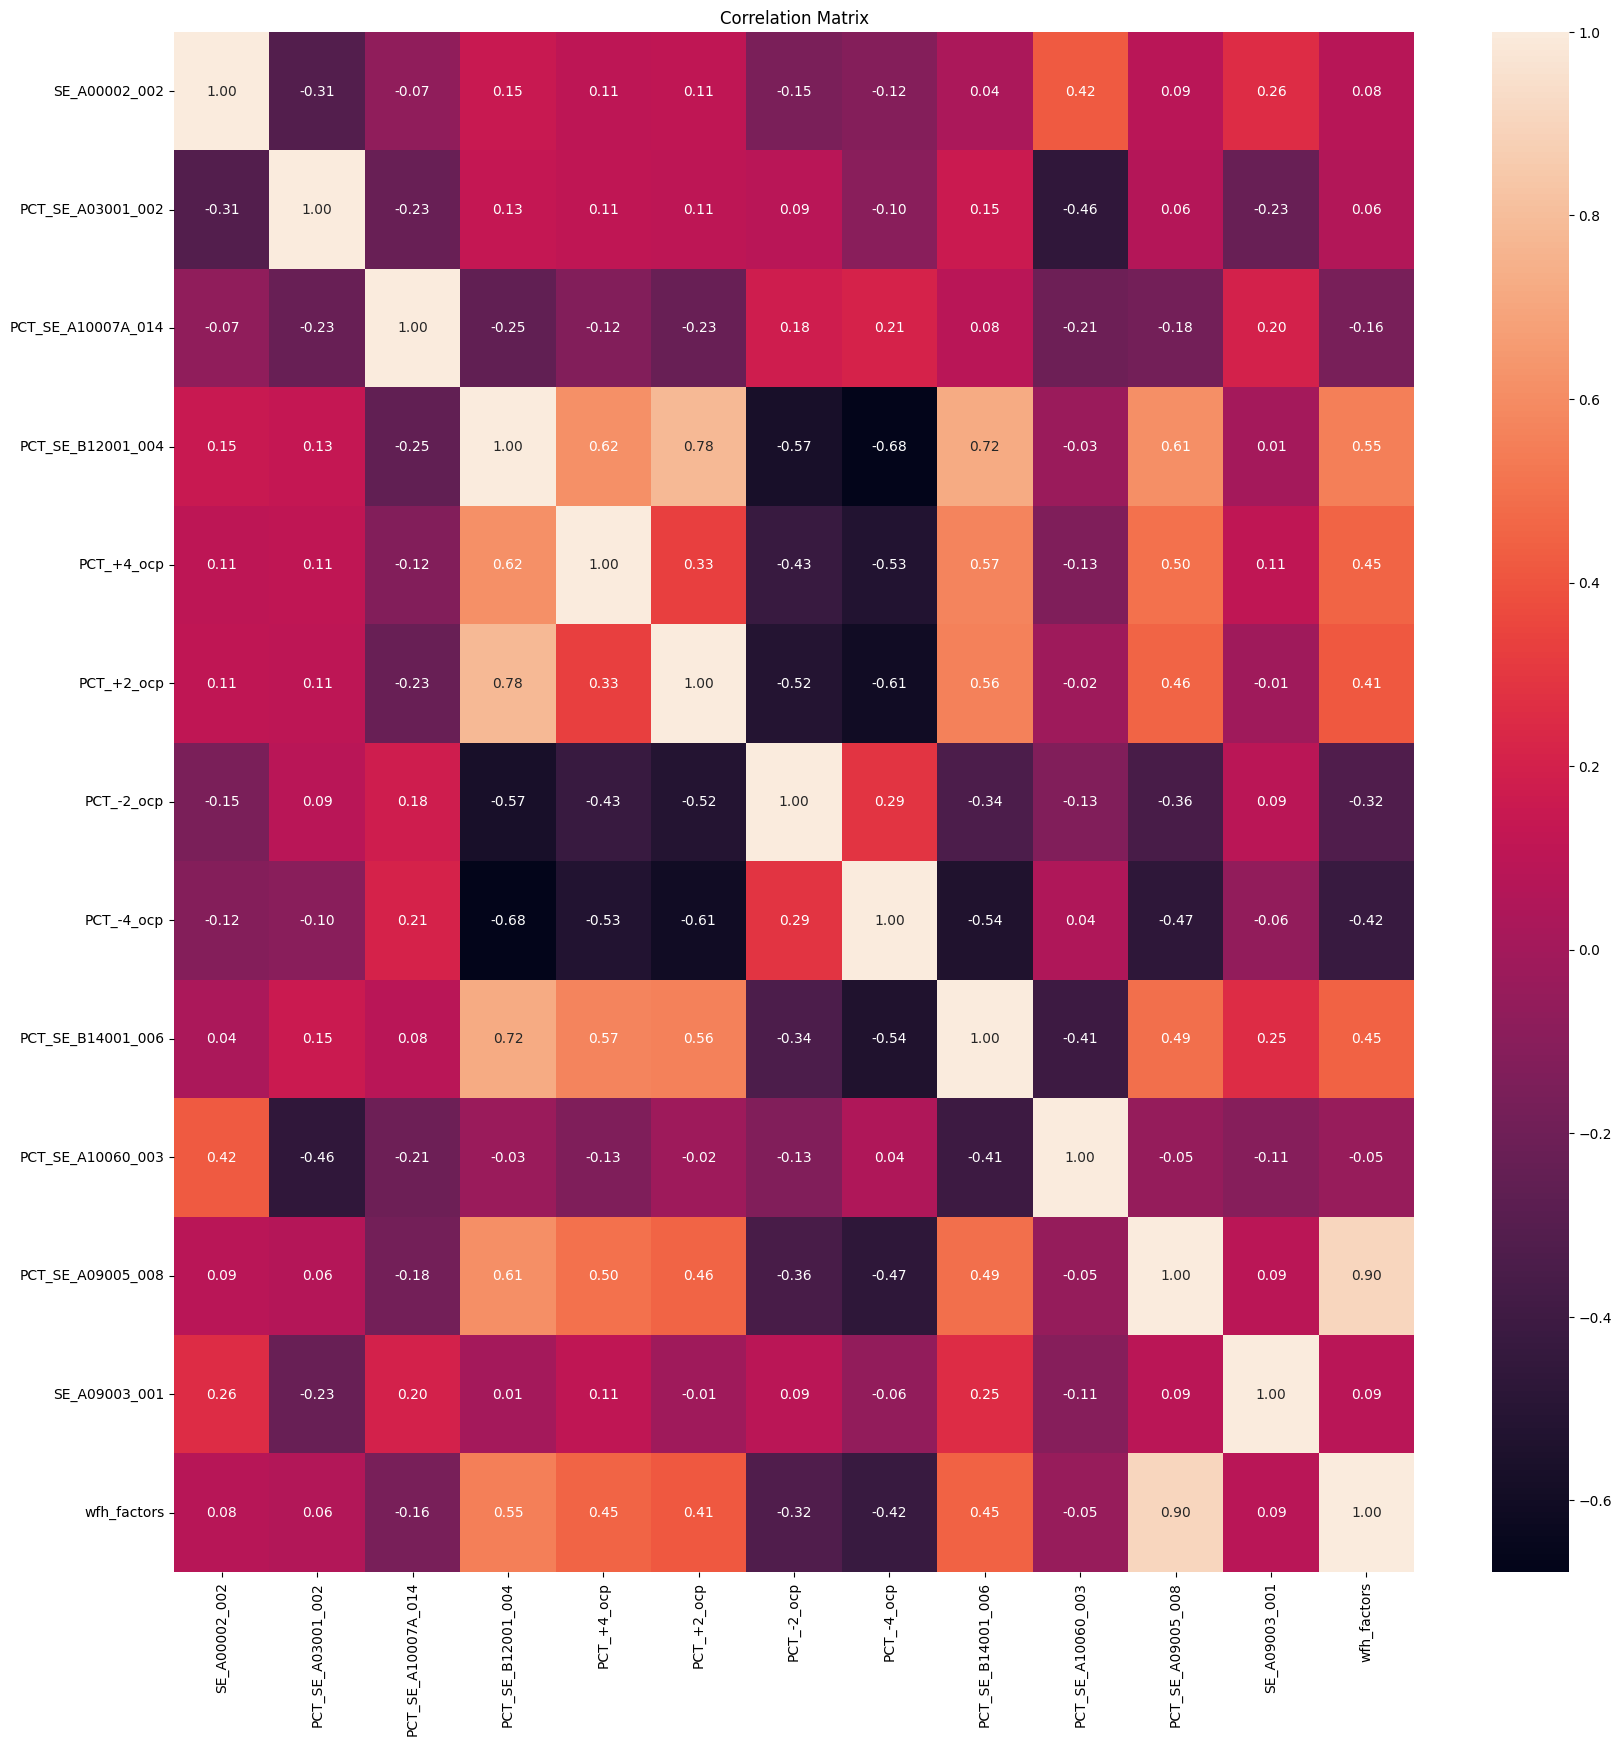

In [45]:

# create a correlation matrix
corr_matrix = corr.corr()
print(corr_matrix['PCT_SE_A09005_008'].sort_values(ascending=False))


# plot a heatmap to visualize the correlations
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

corr_matrix = corr_matrix['PCT_SE_A09005_008']


In [46]:
# ## Clean up df
# corr_viz = census[[
#              # population
#              #'SE_A00001_001', 
#              'SE_A00002_002', 
#              # A00001_001:     Population
#              # A00002_002:     Population Density (Per Sq. Mile)
             
#              # race
#              'PCT_SE_A03001_002', 
#              # A03001_002:      White Alone
             
#              # education level
#              'PCT_SE_B12001_004', #   PCT_B12001_004: % Population 25 Years and Over: Bachelor's Degree or Better

#             'PCT_+4_ocp', 
#             'PCT_+2_ocp', 
#             # 'PCT_+1_ocp', 
#             # 'PCT_-1_ocp', 
#             #'PCT_-2_ocp', 
#             'PCT_-4_ocp',
            
#              # household income
#              'PCT_SE_B14001_006',
#                 #   PCT_B14001_006: % Households: $100,000 or More
             
#              # house value
#              'SE_A10036_001',
#              # A10036_001:     Median House Value for All Owner-Occupied Housing Units - Median Value

#              # WFH rate
#              'PCT_SE_A09005_008',
#              # A09005_001:     Workers 16 Years and Over:
#              #   PCT_A09005_008: % Workers 16 Years and Over: Worked At Home
            
#              # Housing Units by Vehicles Available
#              'PCT_SE_A10030_002',
#              # A10030_002:      No Vehicle Available

#              ]].copy()

# column_name_map = {
#                     'SE_A00002_002': 'Population Density',
#                     'PCT_SE_A03001_002': '% White population',
#                     'PCT_SE_B12001_004': ' % Bachelor or higher',
#                     'PCT_+4_ocp': '% Occupations - Highly likely WFH',
#                     'PCT_+2_ocp': '% Occupations - Very likely WFH',
#                     'PCT_-4_ocp': '% Occupations - Highly unlikely WFH',
#                     'PCT_SE_B14001_006': '% Households income $100,000 or More',
#                     'SE_A10036_001': 'Median House Value',
#                     'PCT_SE_A10030_002': '% No Vehicle household',
#                     'PCT_SE_A09005_008': 'WFH rate'
#                     }

# # Rename the columns using the dictionary
# corr_viz.rename(columns=column_name_map, inplace=True)

# corr_viz.to_csv('/Users/luchen/Documents/Esri/Project/results/demographic/modeling_wfh.csv', index=False)


In [47]:
# # We'll use linear regression to try to predict 'PCT_SE_A09005_008'
# # First, drop the non-numerical columns
# corr = corr.dropna(axis = 0)
# numerical_df = corr.select_dtypes(include=[np.number])
# # numerical_df = numerical_df.dropna(axis=1)  # drop any columns with missing data

# # prepare the data for the model
# X = numerical_df.drop(['PCT_SE_A09005_008'], axis=1)  # feature columns
# y = numerical_df['PCT_SE_A09005_008']  # target column

# # split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # train the model
# model = LinearRegression()
# model.fit(X_train, y_train)

# # make predictions on the test set
# y_pred = model.predict(X_test)

# # print model accuracy
# print("Model Accuracy: ", model.score(X_test, y_test))

# # print root mean squared error of the model
# print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [48]:
#### correlations with 'PCT_SE_A09005_008' > 0.1
# Use boolean indexing to filter out rows with absolute correlation less than threshold
corr_matrix_01 = corr_matrix[corr_matrix.abs() > 0].dropna()

# Now 'filtered_corr_matrix' is your filtered correlation matrix
print(corr_matrix_01.sort_values(ascending=False))

# filter origional df, only keep above variables
cols_to_keep = corr_matrix_01.index.str.split().str[0]
corr_01 = corr[cols_to_keep]

corr_01.head()
corr_01.shape

corr.to_csv('dataframes/corr_01.csv', index=False)


PCT_SE_A09005_008     1.000000
wfh_factors           0.902857
PCT_SE_B12001_004     0.607139
PCT_+4_ocp            0.500444
PCT_SE_B14001_006     0.492522
PCT_+2_ocp            0.455268
SE_A09003_001         0.093398
SE_A00002_002         0.088804
PCT_SE_A03001_002     0.064072
PCT_SE_A10060_003    -0.052855
PCT_SE_A10007A_014   -0.183230
PCT_-2_ocp           -0.358091
PCT_-4_ocp           -0.468714
Name: PCT_SE_A09005_008, dtype: float64


In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set 
X = corr_01  # fill this with the names of your features

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data.sort_values(by='VIF'))

               feature        VIF
0        SE_A00002_002   1.718897
6           PCT_-2_ocp   5.166623
9    PCT_SE_A10060_003   5.735735
7           PCT_-4_ocp   6.127297
1    PCT_SE_A03001_002  11.752338
2   PCT_SE_A10007A_014  14.944380
4           PCT_+4_ocp  15.292906
12         wfh_factors  17.423254
8    PCT_SE_B14001_006  17.759499
11       SE_A09003_001  17.821587
5           PCT_+2_ocp  18.408071
10   PCT_SE_A09005_008  22.636470
3    PCT_SE_B12001_004  26.943064
